In [33]:
# Importing the necessary libraries for the project. 
import pandas as pd 
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
import matplotlib.dates as mdates
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from math import sqrt
# ParameterSampler for randomized hyperparameter sampling, optimizing model parameters in cross-validation.
from sklearn.model_selection import ParameterSampler
# pmdarima's auto_arima for automated selection of the best ARIMA parameters based on AIC/BIC scores.
from pmdarima import auto_arima
# Mean Squared Error and Mean Absolute Error metrics from sklearn for evaluating model accuracy.
from sklearn.metrics import mean_squared_error, mean_absolute_error
# TimeSeriesSplit for cross-validation with time series data to preserve the temporal ordering of data.
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch

import warnings # filter warnings
warnings.filterwarnings('ignore')

# Testing baseline SARIMA with exogenous variables (SARIMAX). 

- **Evaluation of final baseline model will be performed between the comparison of best model with and withou exogenous variables**

In [35]:
# Importing the dataset after the Log Returns transformation.
df1 = pd.read_csv('df1.csv', index_col=0, parse_dates=True)

# Along with the importation, the code will set the date as the index, value of 0 because is the first column.
## Setting parse_dates=true to ensure the dates are in datetime, making more appropriate for ML models.

In [18]:
df1.head()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
Date,,,,,,
2004-04-01,0.012635,0.031461,-0.023861,0.003674,0.000735,117.596902
2004-04-08,-0.010896,0.012635,-0.000125,0.000981,-0.001424,117.741650
2004-04-15,-0.003623,-0.010896,-0.029274,0.007394,-0.000325,0.776477
2004-04-22,-0.001496,-0.003623,0.031461,-0.000845,-0.000305,0.623353
2004-04-29,-0.000784,-0.001496,0.012635,-0.004200,-0.002649,0.647610


In [19]:
df1.describe()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
count,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000
mean,0.001575,0.001608,0.001508,0.001578,0.001516,7.731465
std,0.020723,0.020744,0.020750,0.009796,0.005364,23.505939
min,-0.069935,-0.069935,-0.069935,-0.051352,-0.026288,0.154122
25%,-0.007633,-0.007633,-0.007858,-0.003032,-0.001013,1.538535
50%,0.003635,0.003666,0.003626,0.002937,0.002346,2.585030
75%,0.013568,0.013643,0.013514,0.007596,0.004979,6.157669
max,0.051947,0.051947,0.051947,0.031089,0.019145,338.128664


In [37]:
# Define the selected exogenous variables
ex1 = df1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']]

In [39]:
# Define the split index for the train-test split (85% train, 15% test)
split_index = int(0.90 * len(df1))

# Target variable split
train = df1['Close'][:split_index]
test = df1['Close'][split_index:]

# Exogenous variables split
exo_train = ex1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']][:split_index]
exo_test = ex1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']][split_index:]

- SARIMAX model being tested by random parameters with yearly seasonality (12 weeks). 

The workflow of SARIMAX will follow the same path as the SARIMA: 
- Random parameter: Random values, starting point for hyper-parameter tunning.

- Hyper-parameter tunning: Auto-arima and Random Search. The first will search through combinations that has the lower AIC value and the second will be performed along with cross validation techniques searching for the best RMSE.

- Cross-Validation: Time-Series and Fixed Rolling Window.

- Residuals: The analysis will be performed on the best model.   

**The evaluation of results and performance of each model will be at the end, when all models have being applied along with cross-validation techniques**. 






Performing auto-arima to find optimal parameters using two different frequencies monthly and quaterly. 

                                        SARIMAX Results                                        
Dep. Variable:                                   Close   No. Observations:                  927
Model:             SARIMAX(2, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                2631.030
Date:                                 Mon, 18 Nov 2024   AIC                          -5238.060
Time:                                         15:28:04   BIC                          -5180.076
Sample:                                     04-01-2004   HQIC                         -5215.941
                                          - 12-30-2021                                         
Covariance Type:                                   opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.3987      0.078     17.888      0.000  

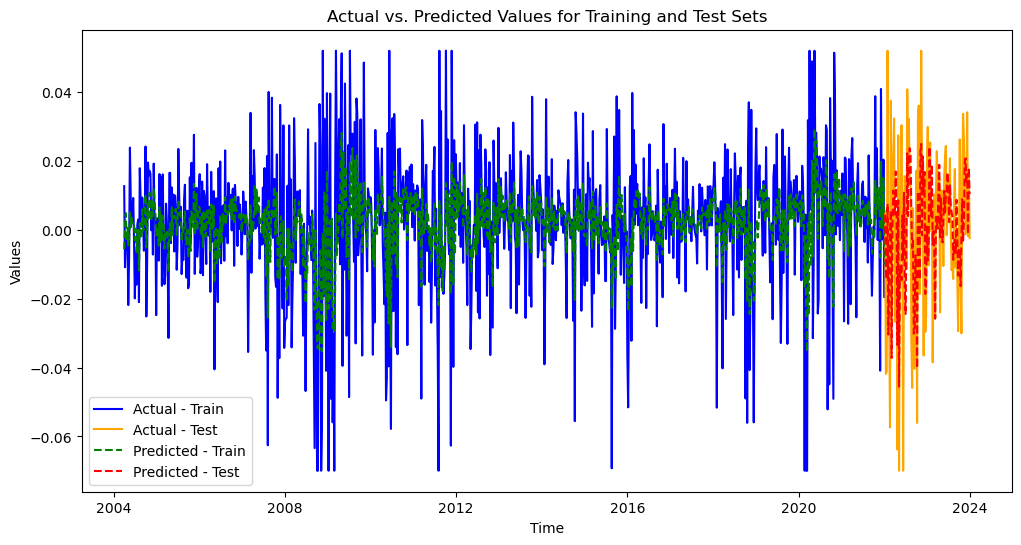

In [10]:
# Define SARIMAX model 
sarimax_model = SARIMAX(train, order=(2, 0, 1), seasonal_order=(1, 0, 2, 12), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

### AUTO-ARIMA

- 52 Weeks Frequency (One Year)

In [12]:
# Sets random seed for reproducibility
np.random.seed(42)

# Perform auto_arima with specified seed and exogenous variables
auto_model = auto_arima(train, 
                        exogenous=exo_train, 
                        seasonal=True,
                        m=52,  # Set seasonality period, e.g., 12 for weekly data with quaterly seasonality
                        trace=True,  # Prints the model selection process
                        error_action='ignore',  # Ignore models that fail to fit
                        suppress_warnings=True,  # Suppress warnings
                        stepwise=True,  # Stepwise approach for faster search
                        random=True,  # Random search
                        random_state=42,  # Seed for reproducibility
                        n_fits=50)  # Number of models to try

# Print the best model found
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=-4604.419, Time=150.72 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=-4610.277, Time=0.38 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=-4611.821, Time=69.94 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=-4612.020, Time=38.03 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=-4605.606, Time=0.70 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=-4612.115, Time=1.00 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=-4611.923, Time=26.52 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=-4609.591, Time=46.65 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=-4610.300, Time=0.36 sec
 ARIMA(0,0,2)(0,0,0)[52] intercept   : AIC=-4610.339, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=-4611.979, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=-4608.263, Time=0.55 sec
 ARIMA(0,0,1)(0,0,0)[52]             : AIC=-4606.517, Time=0.34 sec

Best model:  ARIMA(0,0,1)(0,0,0)[52] intercept
Total fit time: 335

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  927
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 52)   Log Likelihood                2520.841
Date:                            Mon, 18 Nov 2024   AIC                          -5025.682
Time:                                    15:35:42   BIC                          -4987.027
Sample:                                04-01-2004   HQIC                         -5010.937
                                     - 12-30-2021                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.3987      0.081     17.312      0.000       1.240       1.557
rolling_mean_12w 

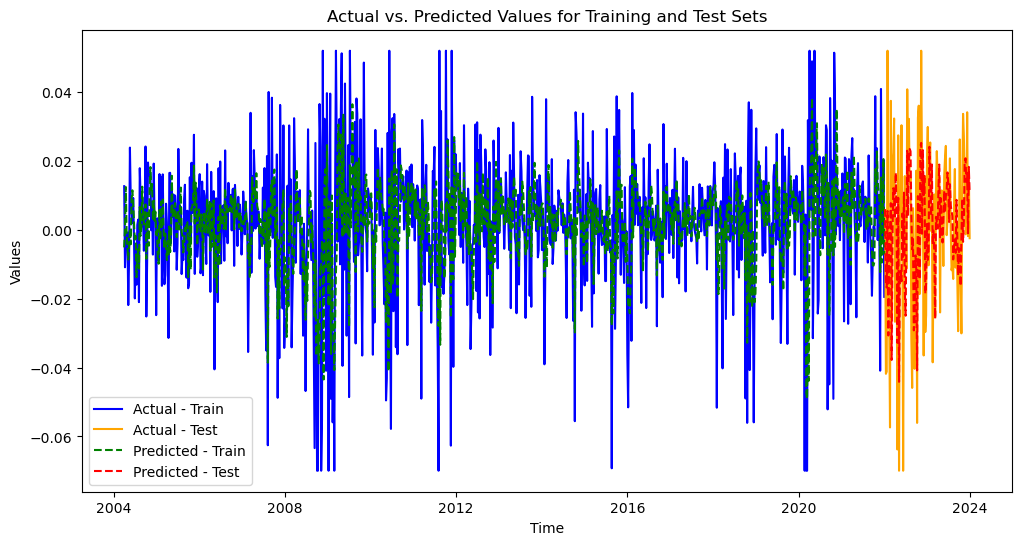

In [13]:
# Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 0, 1, 52), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [14]:
# Sets random seed for reproducibility.
np.random.seed(42)

# Perform auto_arima with specified seed and exogenous variables.
auto_model = auto_arima(train, 
                        exogenous=exo_train, 
                        seasonal=True,
                        m=26,  # Set seasonality period, e.g., 52 for weekly data with yearly seasonality.
                        trace=True,  # Prints the model selection process.
                        error_action='ignore',  # Ignore models that fail to fit.
                        suppress_warnings=True,  # Suppress warnings.
                        stepwise=True,  # Stepwise approach for faster search.
                        random=True,  # Random search.
                        random_state=42,  # Seed for reproducibility.
                        n_fits=50)  # Number of models to try.

# Print the best model found.
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[26] intercept   : AIC=-4603.794, Time=22.31 sec
 ARIMA(0,0,0)(0,0,0)[26] intercept   : AIC=-4610.277, Time=0.32 sec
 ARIMA(1,0,0)(1,0,0)[26] intercept   : AIC=-4610.040, Time=11.65 sec
 ARIMA(0,0,1)(0,0,1)[26] intercept   : AIC=-4610.184, Time=3.79 sec
 ARIMA(0,0,0)(0,0,0)[26]             : AIC=-4605.606, Time=0.22 sec
 ARIMA(0,0,0)(1,0,0)[26] intercept   : AIC=-4608.254, Time=2.83 sec
 ARIMA(0,0,0)(0,0,1)[26] intercept   : AIC=-4608.132, Time=1.80 sec
 ARIMA(0,0,0)(1,0,1)[26] intercept   : AIC=-4606.494, Time=4.47 sec
 ARIMA(1,0,0)(0,0,0)[26] intercept   : AIC=-4611.979, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[26] intercept   : AIC=-4610.046, Time=3.12 sec
 ARIMA(1,0,0)(1,0,1)[26] intercept   : AIC=-4608.289, Time=3.46 sec
 ARIMA(2,0,0)(0,0,0)[26] intercept   : AIC=-4610.365, Time=0.61 sec
 ARIMA(1,0,1)(0,0,0)[26] intercept   : AIC=-4610.300, Time=0.36 sec
 ARIMA(0,0,1)(0,0,0)[26] intercept   : AIC=-4612.115, Time=0.52 sec
 AR

- 26 Weeks Frequency (Half-Year)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  927
Model:               SARIMAX(0, 0, 1)   Log Likelihood                2520.329
Date:                Mon, 18 Nov 2024   AIC                          -5026.659
Time:                        15:36:47   BIC                          -4992.835
Sample:                    04-01-2004   HQIC                         -5013.756
                         - 12-30-2021                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.3987      0.080     17.419      0.000       1.241       1.556
rolling_mean_12w    -0.0471      0.102     -0.460      0.645      -0.248       0.153
volatility_4w     1.224e-05 

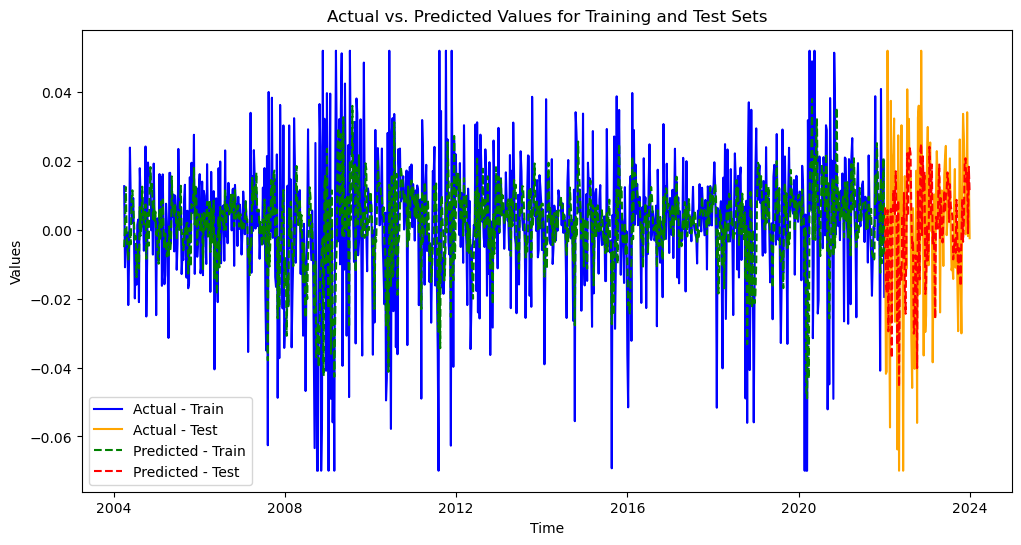

In [16]:
# Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 0, 0, 26), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

- 12 Weeks (Quaterly)

In [18]:
# Sets random seed for reproducibility
np.random.seed(42)

# Perform auto_arima with specified seed and exogenous variables
auto_model = auto_arima(train, 
                        exogenous=exo_train, 
                        seasonal=True,
                        m=12,  # Set seasonality period, e.g., 12 for weekly data with quaterly seasonality
                        trace=True,  # Prints the model selection process
                        error_action='ignore',  # Ignore models that fail to fit
                        suppress_warnings=True,  # Suppress warnings
                        stepwise=True,  # Stepwise approach for faster search
                        random=True,  # Random search
                        random_state=42,  # Seed for reproducibility
                        n_fits=50)  # Number of models to try

# Print the best model found
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-4605.066, Time=7.14 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-4610.277, Time=0.87 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-4612.734, Time=2.58 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-4612.918, Time=3.31 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-4605.606, Time=0.53 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-4612.115, Time=1.39 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-4610.886, Time=3.16 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-4610.992, Time=5.32 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-4612.855, Time=2.65 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-4608.994, Time=9.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-4611.112, Time=1.09 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-4611.019, Time=1.31 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=-4611.084, Time=3.45 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-4612.789, Time=1.54 sec
 ARIM

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  927
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood                2521.775
Date:                            Mon, 18 Nov 2024   AIC                          -5027.551
Time:                                    15:37:44   BIC                          -4988.895
Sample:                                04-01-2004   HQIC                         -5012.805
                                     - 12-30-2021                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.3987      0.081     17.340      0.000       1.241       1.557
rolling_mean_12w 

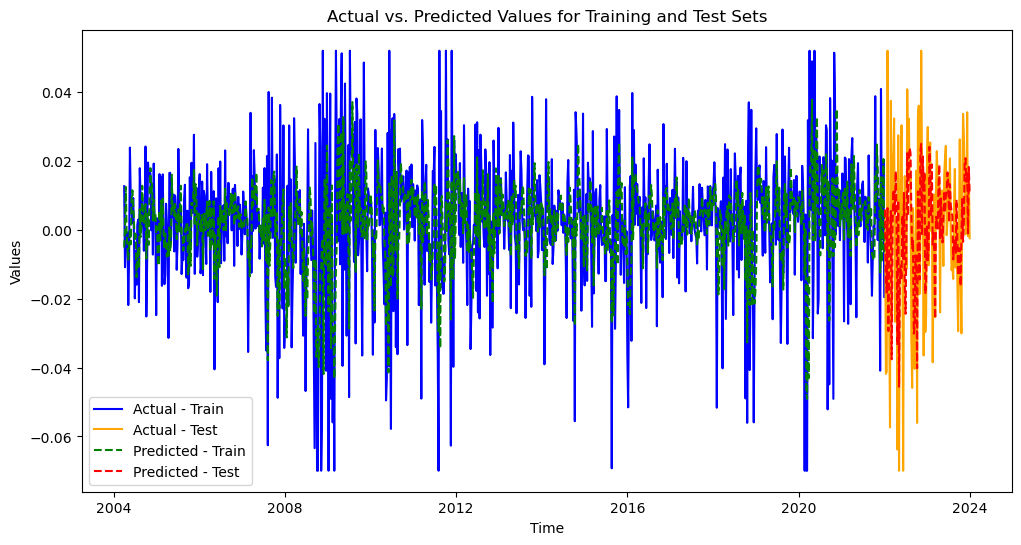

In [19]:
# Define SARIMAX model 
sarimax_model = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 0, 1, 12), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

- With different types of hyper-parameter tunning, the random search will be selected to to find the optimal parameters (30 different). The selection is due to the trade-off between range of values and computational resources (takes too long to run). In addition, a random state will be added to ensure reproducibility (same results).
- Grid Search was attempted but it was extremely computational expensive (especially for m=52).

Instead of applying the random search on a simple train and test set, the approach will be performed along with cross validation, providing a more reliable RMSE across differend folds. Despite being more computational expensive it will validade the model at the same time. 

<b> Six Months Frequency (m=26) </b>

- Random Search 

In [42]:
# Define parameter grid for SARIMA
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [26]  # Seasonal period
}

# Number of random parameter combinations to try
n_iter_search = 30
random_param_list = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Initialize variables to store the best parameters and lowest RMSE
best_rmse = np.inf
best_params = None

# Perform random search
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    try:
        # Fit SARIMA model on the training dataset
        model = sm.tsa.statespace.SARIMAX(
            train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, m),
            exog=exo_train,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        result = model.fit(disp=False)
        
        # Forecast on the test dataset
        forecast = result.predict(start=len(train), end=len(train) + len(test) - 1, exog=exo_test)
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(test, forecast))
        print(f"RMSE for parameters {params}: {rmse}")
        
        # Update best parameters if RMSE improves
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
    except Exception as e:
        print(f"Failed to fit model with parameters {params}: {e}")

# Output the best parameters and RMSE
print(f"Best parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")


Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 26, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}
RMSE for parameters {'q': 2, 'p': 2, 'm': 26, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}: 0.02130237512677686
Testing SARIMA parameters: {'q': 2, 'p': 1, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}
RMSE for parameters {'q': 2, 'p': 1, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}: 0.03637220105931244
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 26, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}
RMSE for parameters {'q': 2, 'p': 2, 'm': 26, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}: 0.03602653985859256
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}
RMSE for parameters {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}: 0.051262234793297015
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
RMSE for parameters {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}: 0.05622726940069319
Testing SARIMA parameters: {'q': 0, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D

                                        SARIMAX Results                                        
Dep. Variable:                                   Close   No. Observations:                  927
Model:             SARIMAX(1, 0, 0)x(0, 1, [1, 2], 26)   Log Likelihood                2396.458
Date:                                 Tue, 19 Nov 2024   AIC                          -4774.915
Time:                                         18:33:35   BIC                          -4731.684
Sample:                                     04-01-2004   HQIC                         -4758.402
                                          - 12-30-2021                                         
Covariance Type:                                   opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.3889      0.069     20.100      0.000  

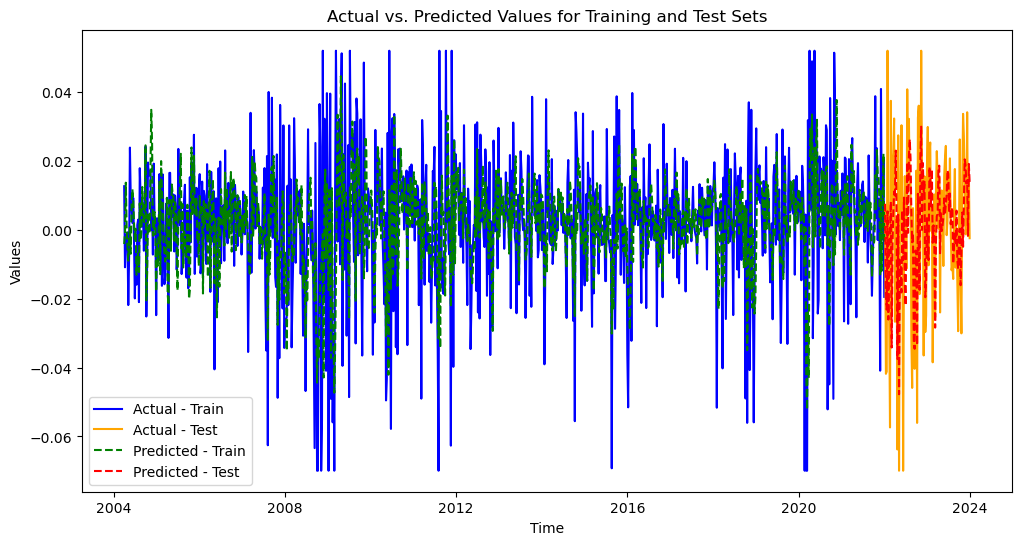

In [62]:
# Define SARIMAX model 
sarimax_model = SARIMAX(train, order=(1, 0, 0), seasonal_order=(0, 1, 2, 26), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

- TSCV

In [50]:
# Optimal parameters from random search
optimal_params = {
    'p': 1,   
    'd': 0,   
    'q': 0,  
    'P': 0,   
    'D': 1,   
    'Q': 2,   
    'm': 26   # (seasonal period)
}
p, d, q = optimal_params['p'], optimal_params['d'], optimal_params['q']
P, D, Q, m = optimal_params['P'], optimal_params['D'], optimal_params['Q'], optimal_params['m']

# TSCV Setup
n_splits = 4
test_window = 50
initial_train_window = len(train) - n_splits * test_window

# Function to evaluate SARIMA with TSCV
def tscv_evaluate_sarima(params):
    """
    Perform TSCV on SARIMA with given parameters and return average RMSE.
    """
    rmse_scores = []
    
    for i in range(n_splits):
        # Define train and test indices for each fold
        train_end = initial_train_window + i * test_window
        test_end = train_end + test_window
        
        y_train, y_test = train[:train_end], train[train_end:test_end]
        X_train, X_test = exo_train[:train_end], exo_train[train_end:test_end]
        
        try:
            # Fit SARIMA model
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                exog=X_train,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)
            
            # Forecast on the test set
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE
            rmse = mean_squared_error(y_test, forecast, squared=False)
            rmse_scores.append(rmse)
        except Exception as e:
            print(f"Failed on fold {i+1}: {e}")
            return np.inf  # Assign high error if model fails
    
    # Return the average RMSE across all folds
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Run TSCV evaluation
tscv_rmse = tscv_evaluate_sarima(optimal_params)
print(f"TSCV Average RMSE: {tscv_rmse}")

TSCV Average RMSE: 0.01781910390923587


- Fixed Rolling Window CV

In [51]:
# Fixed Rolling Window Setup
window_size = 300  # Training window size
test_size = 50     # Test window size

# Function to evaluate SARIMA with fixed rolling window
def fixed_rolling_evaluate_sarima(params):
    """
    Perform Fixed Rolling Window evaluation on SARIMA with given parameters and return average RMSE.
    """
    rolling_rmses = []
    
    for i in range(0, len(train) - window_size - test_size, test_size):
        y_train = train[i:i + window_size]
        y_test = train[i + window_size:i + window_size + test_size]
        X_train = exo_train[i:i + window_size]
        X_test = exo_train[i + window_size:i + window_size + test_size]
        
        try:
            # Fit SARIMA model
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                exog=X_train,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)
            
            # Forecast on the test set
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_test, forecast))
            rolling_rmses.append(rmse)
        except Exception as e:
            print(f"Failed on rolling window iteration {i+1}: {e}")
            rolling_rmses.append(np.inf)
    
    # Return the average RMSE across all rolling windows
    avg_rmse = np.mean(rolling_rmses)
    return avg_rmse

# Run Fixed Rolling Window evaluation
fixed_rolling_rmse = fixed_rolling_evaluate_sarima(optimal_params)
print(f"Fixed Rolling Window Average RMSE: {fixed_rolling_rmse}")

Fixed Rolling Window Average RMSE: 0.01672927492214718


<b> Quaterly frequency (m=12) </b>
- Random Search 

In [41]:
# Define parameter grid for SARIMA
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [12]  # Seasonal period
}

# Number of random parameter combinations to try
n_iter_search = 30
random_param_list = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Initialize variables to store the best parameters and lowest RMSE
best_rmse = np.inf
best_params = None

# Perform random search
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    try:
        # Fit SARIMA model on the training dataset
        model = sm.tsa.statespace.SARIMAX(
            train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, m),
            exog=exo_train,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        result = model.fit(disp=False)
        
        # Forecast on the test dataset
        forecast = result.predict(start=len(train), end=len(train) + len(test) - 1, exog=exo_test)
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(test, forecast))
        print(f"RMSE for parameters {params}: {rmse}")
        
        # Update best parameters if RMSE improves
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
    except Exception as e:
        print(f"Failed to fit model with parameters {params}: {e}")

# Output the best parameters and RMSE
print(f"Best parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 12, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}
RMSE for parameters {'q': 2, 'p': 2, 'm': 12, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}: 0.021321244715097297
Testing SARIMA parameters: {'q': 2, 'p': 1, 'm': 12, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}
RMSE for parameters {'q': 2, 'p': 1, 'm': 12, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}: 0.03296783801216591
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 12, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}
RMSE for parameters {'q': 2, 'p': 2, 'm': 12, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}: 0.03934288937808611
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}
RMSE for parameters {'q': 2, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}: 0.08925134374336238
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
RMSE for parameters {'q': 2, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}: 0.142395345944807
Testing SARIMA parameters: {'q': 0, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 'P': 1, 'D':

                                        SARIMAX Results                                        
Dep. Variable:                                   Close   No. Observations:                  927
Model:             SARIMAX(1, 0, 0)x(0, 1, [1, 2], 12)   Log Likelihood                2426.265
Date:                                 Tue, 19 Nov 2024   AIC                          -4834.529
Time:                                         18:33:42   BIC                          -4791.159
Sample:                                     04-01-2004   HQIC                         -4817.975
                                          - 12-30-2021                                         
Covariance Type:                                   opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.3614      0.071     19.123      0.000  

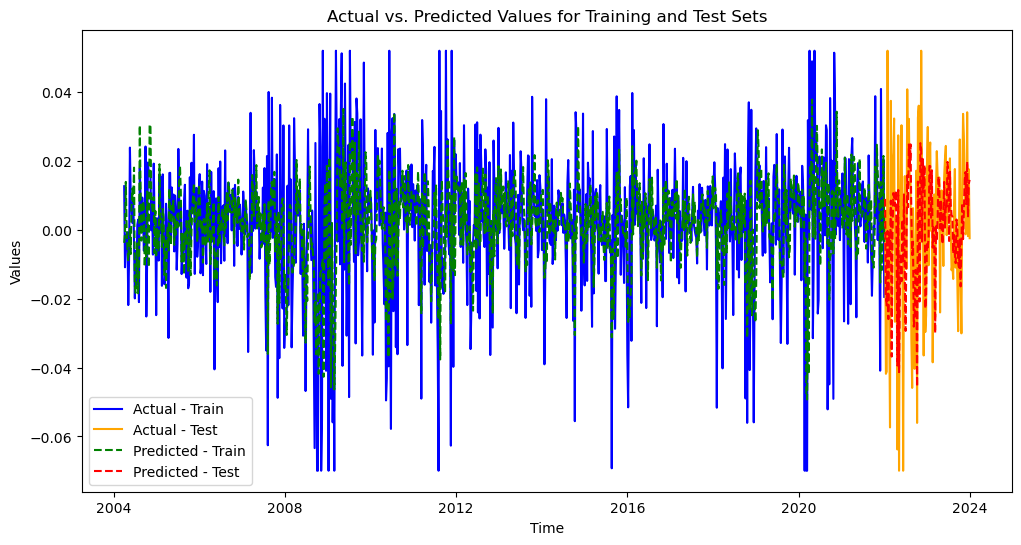

In [63]:
# Define SARIMAX model 
sarimax_model = SARIMAX(train, order=(1, 0, 0), seasonal_order=(0, 1, 2, 12), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

- TSCV

In [52]:
# Optimal parameters from random search
optimal_params = {
    'p': 1,   
    'd': 0,   
    'q': 0,  
    'P': 0,   
    'D': 1,   
    'Q': 2,   
    'm': 12   # (seasonal period)
}
p, d, q = optimal_params['p'], optimal_params['d'], optimal_params['q']
P, D, Q, m = optimal_params['P'], optimal_params['D'], optimal_params['Q'], optimal_params['m']

# TSCV Setup
n_splits = 4
test_window = 50
initial_train_window = len(train) - n_splits * test_window

# Function to evaluate SARIMA with TSCV
def tscv_evaluate_sarima(params):
    """
    Perform TSCV on SARIMA with given parameters and return average RMSE.
    """
    rmse_scores = []
    
    for i in range(n_splits):
        # Define train and test indices for each fold
        train_end = initial_train_window + i * test_window
        test_end = train_end + test_window
        
        y_train, y_test = train[:train_end], train[train_end:test_end]
        X_train, X_test = exo_train[:train_end], exo_train[train_end:test_end]
        
        try:
            # Fit SARIMA model
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                exog=X_train,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)
            
            # Forecast on the test set
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE
            rmse = mean_squared_error(y_test, forecast, squared=False)
            rmse_scores.append(rmse)
        except Exception as e:
            print(f"Failed on fold {i+1}: {e}")
            return np.inf  # Assign high error if model fails
    
    # Return the average RMSE across all folds
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Run TSCV evaluation
tscv_rmse = tscv_evaluate_sarima(optimal_params)
print(f"TSCV Average RMSE: {tscv_rmse}")

TSCV Average RMSE: 0.01784321039600462


- Fixed Rolling Window CV

In [53]:
# Fixed Rolling Window Setup
window_size = 300  # Training window size
test_size = 50     # Test window size

# Function to evaluate SARIMA with fixed rolling window
def fixed_rolling_evaluate_sarima(params):
    """
    Perform Fixed Rolling Window evaluation on SARIMA with given parameters and return average RMSE.
    """
    rolling_rmses = []
    
    for i in range(0, len(train) - window_size - test_size, test_size):
        y_train = train[i:i + window_size]
        y_test = train[i + window_size:i + window_size + test_size]
        X_train = exo_train[i:i + window_size]
        X_test = exo_train[i + window_size:i + window_size + test_size]
        
        try:
            # Fit SARIMA model
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                exog=X_train,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)
            
            # Forecast on the test set
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_test, forecast))
            rolling_rmses.append(rmse)
        except Exception as e:
            print(f"Failed on rolling window iteration {i+1}: {e}")
            rolling_rmses.append(np.inf)
    
    # Return the average RMSE across all rolling windows
    avg_rmse = np.mean(rolling_rmses)
    return avg_rmse

# Run Fixed Rolling Window evaluation
fixed_rolling_rmse = fixed_rolling_evaluate_sarima(optimal_params)
print(f"Fixed Rolling Window Average RMSE: {fixed_rolling_rmse}")

Fixed Rolling Window Average RMSE: 0.016281632464308825


<b>Annual Frequency m=52</b>
- Random Search 

In [43]:
# Define parameter grid for SARIMA
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [52]  # Seasonal period
}

# Number of random parameter combinations to try
n_iter_search = 30
random_param_list = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Initialize variables to store the best parameters and lowest RMSE
best_rmse = np.inf
best_params = None

# Perform random search
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    try:
        # Fit SARIMA model on the training dataset
        model = sm.tsa.statespace.SARIMAX(
            train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, m),
            exog=exo_train,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        result = model.fit(disp=False)
        
        # Forecast on the test dataset
        forecast = result.predict(start=len(train), end=len(train) + len(test) - 1, exog=exo_test)
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(test, forecast))
        print(f"RMSE for parameters {params}: {rmse}")
        
        # Update best parameters if RMSE improves
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
    except Exception as e:
        print(f"Failed to fit model with parameters {params}: {e}")

# Output the best parameters and RMSE
print(f"Best parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 52, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}
RMSE for parameters {'q': 2, 'p': 2, 'm': 52, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}: 0.021454077996755735
Testing SARIMA parameters: {'q': 2, 'p': 1, 'm': 52, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}
RMSE for parameters {'q': 2, 'p': 1, 'm': 52, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}: 0.03384437744277542
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 52, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}
RMSE for parameters {'q': 2, 'p': 2, 'm': 52, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}: 0.03541975363630876
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 52, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}
RMSE for parameters {'q': 2, 'p': 0, 'm': 52, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}: 0.07008262830027497
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 52, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
RMSE for parameters {'q': 2, 'p': 0, 'm': 52, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}: 0.039182700221755316
Testing SARIMA parameters: {'q': 0, 'p': 0, 'm': 52, 'd': 1, 'Q': 0, 'P': 1, '

                                        SARIMAX Results                                        
Dep. Variable:                                   Close   No. Observations:                  927
Model:             SARIMAX(1, 0, 0)x(0, 1, [1, 2], 52)   Log Likelihood                2296.571
Date:                                 Tue, 19 Nov 2024   AIC                          -4575.141
Time:                                         18:38:57   BIC                          -4532.173
Sample:                                     04-01-2004   HQIC                         -4558.705
                                          - 12-30-2021                                         
Covariance Type:                                   opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.4307      0.074     19.445      0.000  

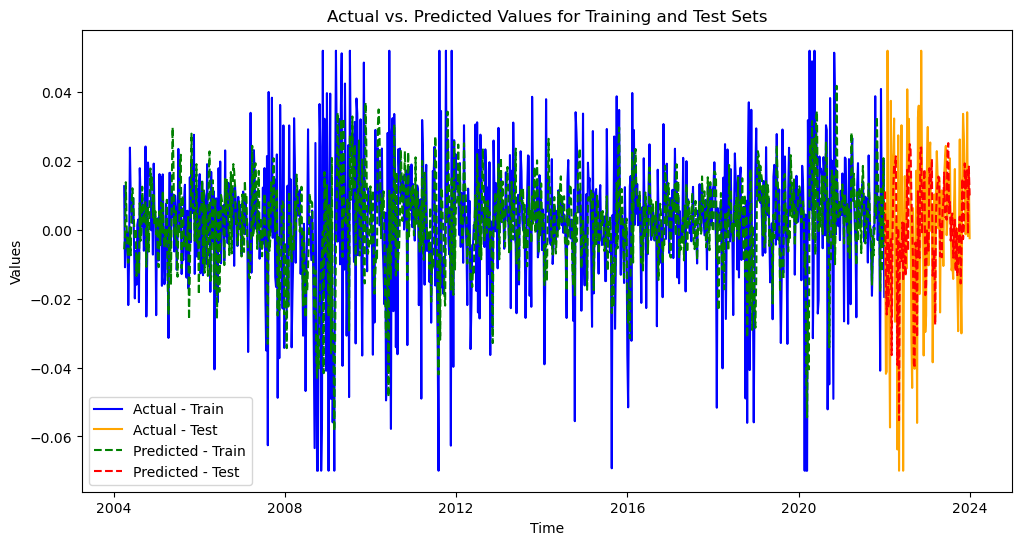

In [64]:
# Define SARIMAX model 
sarimax_model = SARIMAX(train, order=(1, 0, 0), seasonal_order=(0, 1, 2, 52), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

- TSCV

In [54]:
# Optimal parameters from random search
optimal_params = {
    'p': 1,   
    'd': 0,   
    'q': 0,  
    'P': 0,   
    'D': 1,   
    'Q': 2,   
    'm': 52   # (seasonal period)
}
p, d, q = optimal_params['p'], optimal_params['d'], optimal_params['q']
P, D, Q, m = optimal_params['P'], optimal_params['D'], optimal_params['Q'], optimal_params['m']

# TSCV Setup
n_splits = 4
test_window = 50
initial_train_window = len(train) - n_splits * test_window

# Function to evaluate SARIMA with TSCV
def tscv_evaluate_sarima(params):
    """
    Perform TSCV on SARIMA with given parameters and return average RMSE.
    """
    rmse_scores = []
    
    for i in range(n_splits):
        # Define train and test indices for each fold
        train_end = initial_train_window + i * test_window
        test_end = train_end + test_window
        
        y_train, y_test = train[:train_end], train[train_end:test_end]
        X_train, X_test = exo_train[:train_end], exo_train[train_end:test_end]
        
        try:
            # Fit SARIMA model
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                exog=X_train,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)
            
            # Forecast on the test set
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE
            rmse = mean_squared_error(y_test, forecast, squared=False)
            rmse_scores.append(rmse)
        except Exception as e:
            print(f"Failed on fold {i+1}: {e}")
            return np.inf  # Assign high error if model fails
    
    # Return the average RMSE across all folds
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Run TSCV evaluation
tscv_rmse = tscv_evaluate_sarima(optimal_params)
print(f"TSCV Average RMSE: {tscv_rmse}")

TSCV Average RMSE: 0.018211114739196524


- Fixed Rolling Window CV

In [55]:
# Fixed Rolling Window Setup
window_size = 300  # Training window size
test_size = 50     # Test window size

# Function to evaluate SARIMA with fixed rolling window
def fixed_rolling_evaluate_sarima(params):
    """
    Perform Fixed Rolling Window evaluation on SARIMA with given parameters and return average RMSE.
    """
    rolling_rmses = []
    
    for i in range(0, len(train) - window_size - test_size, test_size):
        y_train = train[i:i + window_size]
        y_test = train[i + window_size:i + window_size + test_size]
        X_train = exo_train[i:i + window_size]
        X_test = exo_train[i + window_size:i + window_size + test_size]
        
        try:
            # Fit SARIMA model
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                exog=X_train,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)
            
            # Forecast on the test set
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_test, forecast))
            rolling_rmses.append(rmse)
        except Exception as e:
            print(f"Failed on rolling window iteration {i+1}: {e}")
            rolling_rmses.append(np.inf)
    
    # Return the average RMSE across all rolling windows
    avg_rmse = np.mean(rolling_rmses)
    return avg_rmse

# Run Fixed Rolling Window evaluation
fixed_rolling_rmse = fixed_rolling_evaluate_sarima(optimal_params)
print(f"Fixed Rolling Window Average RMSE: {fixed_rolling_rmse}")

Fixed Rolling Window Average RMSE: 0.01805789213060784


## Model Performance: Auto-Arima vs. Random Search for Different Seasonalities

### Seasonality = 12
| Metric         | Auto-Arima    | Random Search  |
|-----------------|---------------|----------------|
| **Train RMSE** | 0.015931236   | 0.016933963    |
| **Test RMSE**  | 0.02126433    | 0.021053074    |
| **Train MAE**  | 0.011723507   | 0.012624419    |
| **Test MAE**   | 0.016999696   | 0.016839804    |
| **Train DA**   | 99%           | 99%            |
| **Test DA**    | 98%           | 98%            |

---

### Seasonality = 26
| Metric         | Auto-Arima    | Random Search  |
|-----------------|---------------|----------------|
| **Train RMSE** | 0.015956767   | 0.01665377     |
| **Test RMSE**  | 0.021247705   | 0.021168767    |
| **Train MAE**  | 0.011748055   | 0.012294922    |
| **Test MAE**   | 0.016997872   | 0.016849384    |
| **Train DA**   | 99%           | 99%            |
| **Test DA**    | 98%           | 98%            |

---

### Seasonality = 52
| Metric         | Auto-Arima    | Random Search  |
|-----------------|---------------|----------------|
| **Train RMSE** | 0.015946785   | 0.017119252    |
| **Test RMSE**  | 0.021320255   | 0.02083639     |
| **Train MAE**  | 0.011745957   | 0.012898983    |
| **Test MAE**   | 0.017060656   | 0.016342195    |
| **Train DA**   | 99%           | 99%            |
| **Test DA**    | 98%           | 98%            |

---

# Cross-Validation Results for Best Performers

### Seasonality = 12
| Cross-Validation Type                      | RMSE          |
|--------------------------------------------|---------------|
| **Time Series Cross-Validation (TSCV)**    | 0.01784321    |
| **Forward Rolling Window Cross-Validation (RFWCV)** | 0.016281632   |

---

### Seasonality = 26
| Cross-Validation Type                      | RMSE          |
|--------------------------------------------|---------------|
| **Time Series Cross-Validation (TSCV)**    | 0.017819104   |
| **Forward Rolling Window Cross-Validation (RFWCV)** | 0.016729274   |

---

### Seasonality = 52
| Cross-Validation Type                      | RMSE          |
|--------------------------------------------|---------------|
| **Time Series Cross-Validation (TSCV)**    | 0.018211115   |
| **Forward Rolling Window Cross-Validation (RFWCV)** | 0.018057892   |




**Based on the results, the model that best performed under the 90-10 train and test split is the one with annual frequency (m=52)**.

The model m=52 from Random search parameters):
- Presented lower test RMSE and MAE scores.
- The CV scores are the highest between the seasonalities, however the CV scores metrics are similiar for both techniques and closer to the RMSE.
- In addition the RMSE from the both CV's are close to the RMSE test. 